In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [2]:
from pyts.datasets import load_gunpoint
from pyts.image import GramianAngularField

In [3]:
from multiprocessing import Pool, cpu_count

In [7]:
fp = 'data_vol.csv'
data = pd.read_csv(fp, parse_dates=['time'])
# data.set_index('time', inplace=True)

In [10]:
data.tail()

,time,open,high,low,close,volume,Day_Perc_Change,Volatility
1199,2020-03-25 08:34:00-04:00,106.84000,106.99800,106.800,106.998,15090,0.155384,107.1060
1200,2020-03-25 08:33:00-04:00,106.98998,106.98998,106.900,106.900,9010,-0.091590,107.0260
1201,2020-03-25 08:32:00-04:00,106.80000,107.00000,106.800,106.990,16855,0.084191,106.9840
1202,2020-03-25 08:31:00-04:00,106.40000,106.80000,106.400,106.800,13420,-0.177587,106.9040
1203,2020-03-25 08:30:00-04:00,106.69600,106.79800,106.696,106.798,3400,-0.001873,106.8972


In [14]:
data.time[0].date()

datetime.date(2020, 4, 23)

In [23]:
data.time.apply(lambda x:x.date())[0]#.value_counts()

datetime.date(2020, 4, 23)

In [25]:
import datetime

In [26]:
date_20200325 = data[data['time'].apply(lambda x:x.date())==datetime.date(2020, 4, 23)]

In [28]:
date_20200325.head()

,time,open,high,low,close,volume,Day_Perc_Change,Volatility
0,2020-04-23 09:30:00-04:00,145.25600,145.37400,145.25600,145.37400,43270,-0.151791,145.039104
1,2020-04-23 09:29:00-04:00,146.33800,146.33800,145.20000,145.20000,45200,-0.119691,145.070604
2,2020-04-23 09:24:00-04:00,146.44992,146.44992,146.44992,146.44992,3720,0.860826,145.464984
3,2020-04-23 09:23:00-04:00,146.36000,146.45000,146.34200,146.45000,19410,0.000055,145.813784
4,2020-04-23 09:22:00-04:00,146.30000,146.30000,146.30000,146.30000,3600,-0.102424,145.954784


In [6]:
# data.time[0]

In [35]:
data.time.max()-data.time.min()
# print(data.shape)

Timedelta('29 days 01:00:00')

In [20]:
data.isnull().sum()

open               0
high               0
low                0
close              0
volume             0
Day_Perc_Change    0
Volatility         0
dtype: int64

In [31]:
date_20200325 =date_20200325.set_index('time')

In [32]:
# Scale the data to be between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1))
df = scaler.fit_transform(date_20200325)

In [33]:
# did not flatten the images
gadf = GramianAngularField(sample_range=(-1,1), method='difference')

In [34]:
# transform times series to images
# polar coordinate relationships
X_new = gadf.transform(df)
X_new.shape

(56, 7, 7)

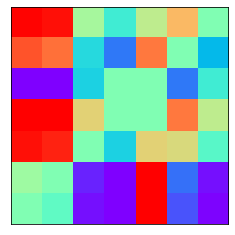

In [40]:
fig = plt.figure()
ax = plt.subplot(111)

fname = f'imgs/{1}.png'

ax.imshow(X_new[1], cmap='rainbow', origin='lower')
ax.set_title('')
ax.set_xticks([])
ax.set_yticks([])

fig.savefig(fname, bbox_inches='tight')

In [50]:
def convert_img(idx):
    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    try:
        fname = f'imgs/{idx}.png'
        if os.path.exists(fname):
            return
    except:
        return
    
    ax.imshow(X_new[idx], cmap='rainbow', origin='lower')
    ax.set_title('')
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.savefig(fname, bbox_inches='tight')

In [51]:
p = Pool(cpu_count())

In [39]:
p

<multiprocessing.pool.Pool state=RUN pool_size=8>

In [53]:
_ = p.map(convert_img, (i for i in range(29)))

KeyboardInterrupt: 